In [1]:
import os
import json
import time
import numpy as np
import xarray as xr
import pandas as pd
import dask.array as da
import geopandas as gpd

import cartopy.crs as ccrs

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from multiprocessing import Pool

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath(".."))
from function import DOWN_raw

In [2]:
npix = 3

# product, time_reso, buffer = 'CMORPH', '3h', 0.50*npix*0.25
product, time_reso, buffer = 'ERA5', '3h', 0.50*npix*0.25
# product, time_reso, buffer = 'IMERG', '3h', 0.25*npix*0.25
# product, time_reso, buffer = 'MSWEP', '3h', 0.25*npix*0.25
# product, time_reso, buffer = 'GSMaP', '3h', 0.25*npix*0.25
# product, time_reso, buffer = 'GSMaP', '3h', 0.25*npix*0.25

yy_s, yy_e = 2002, 2012
years_num = yy_e - yy_s + 1

thresh = 1
acf_fun = 'mar'
Tr = np.array([5, 10, 20, 50, 100])

nproces = 26

# Test area
lon_min, lon_max, lat_min, lat_max = 11, 11.5, 46, 46.5
# Veneto
# lon_min, lon_max, lat_min, lat_max = 10.5, 13.5, 44.5, 47

In [3]:
json_read = f'../json/{product}_{time_reso}.json'

if os.path.exists(json_read):
    with open (json_read) as f:
        param = json.load(f)
else:
    raise SystemExit(f"File not found: {json_read}")

NEIBHR = 2*param['npix']+1

print(f'Read json file   : {json_read.split('/')[-1]}')
print(f'Number of threads: {param['BETA_cores']}')
print(f'Neighborhood area: {NEIBHR}x{NEIBHR}')
print()

Read json file   : ERA5_3h.json
Number of threads: 20
Neighborhood area: 3x3



In [4]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy')

In [5]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [6]:
print(f'Reading data: {param['file']}')
if product == 'SM2RAIN':
    dir_data = os.path.join(dir_base,'Satellite',product,'ASCAT',time_reso,param['file'])
else:
    dir_data = os.path.join(dir_base,'Satellite',product,time_reso,param['file'])

PRE_data = xr.open_dataset(dir_data)
PRE_data = PRE_data.sel(time=PRE_data.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))

if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN' or product == 'ERA5' or product == 'GSMaP':
    PRE_data = PRE_data.sel(lat=slice(lat_max+1, lat_min-1), lon=slice(lon_min-1, lon_max+1))
else:
    PRE_data = PRE_data.sel(lat=slice(lat_min-1, lat_max+1), lon=slice(lon_min-1, lon_max+1))

lats = PRE_data['lat'].data
lons = PRE_data['lon'].data

lon2d, lat2d = np.meshgrid(lons, lats)

nlon = np.size(lons)
nlat = np.size(lats)
ntime = len(PRE_data['time'])

year_vector = np.unique(pd.to_datetime(PRE_data['time']).year)

PRE_data = PRE_data.where(PRE_data >= 0)  # Reemplaza valores negativos con NaN

PRE_data

Reading data: ERA5_Italy_3h_2000_01_01_2023_12_31.nc


<xarray.Dataset> Size: 16MB
Dimensions:  (time: 32144, lat: 11, lon: 11)
Coordinates:
  * time     (time) datetime64[ns] 257kB 2002-01-01 ... 2012-12-31T21:00:00
  * lat      (lat) float64 88B 47.5 47.25 47.0 46.75 ... 45.75 45.5 45.25 45.0
  * lon      (lon) float64 88B 10.0 10.25 10.5 10.75 ... 11.75 12.0 12.25 12.5
Data variables:
    PRE      (time, lat, lon) float32 16MB 0.02861 0.02766 0.01812 ... 0.0 0.0
Attributes:
    description:  ERA5 3 hours data for Italy region

In [7]:
# Extracting lat and lon points for Study area (VENETO)
if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN' or product == 'ERA5' or product == 'GSMaP':
    ds_veneto = PRE_data.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))
else:
    ds_veneto = PRE_data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

if time_reso == '3h':
    PRE_mean = ds_veneto.resample(time ='D').sum(dim='time', skipna=False).mean(dim='time', skipna=True)
elif time_reso == '1dy':
    PRE_mean = ds_veneto.mean(dim='time', skipna=True)
else:
    raise SystemExit(f"Time resolution not found: {time_reso}")

lat_ref = ds_veneto.lat.values
lon_ref = ds_veneto.lon.values

ndices_lat = np.where(np.isin(lats, lat_ref))[0]
ndices_lon = np.where(np.isin(lons, lon_ref))[0]

lon2d_ref, lat2d_ref = np.meshgrid(lon_ref, lat_ref)

del ds_veneto

PRE_mean

<xarray.Dataset> Size: 84B
Dimensions:  (lat: 3, lon: 3)
Coordinates:
  * lat      (lat) float64 24B 46.5 46.25 46.0
  * lon      (lon) float64 24B 11.0 11.25 11.5
Data variables:
    PRE      (lat, lon) float32 36B 3.781 2.966 2.716 4.17 ... 3.654 3.325 4.51

Text(0.0, 1.0, '(c) 3h maximum rainfall')

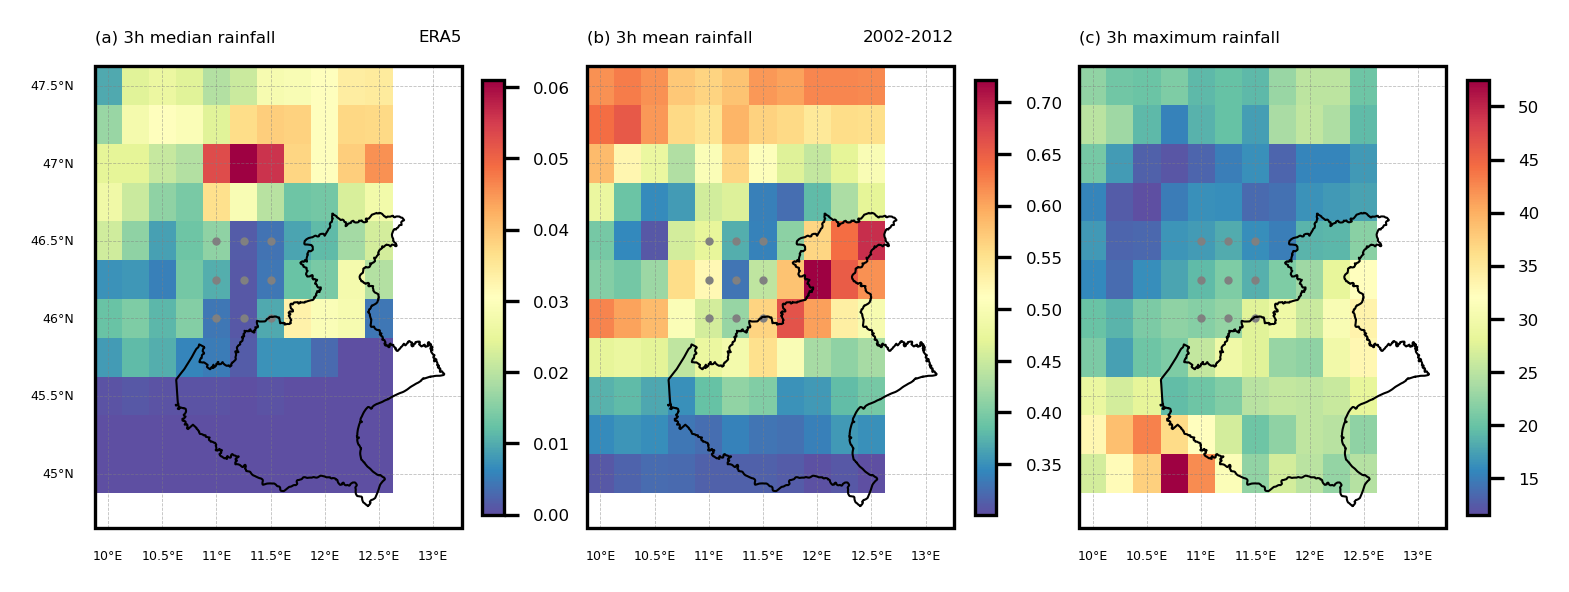

In [8]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,2),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
# ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)

a1 = ax1.pcolormesh(lon2d, lat2d, PRE_data['PRE'].median(dim='time',skipna=True),cmap=cmap)
ax1.scatter(lon2d_ref, lat2d_ref,s=1,c='gray')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(a) {time_reso} median rainfall', fontsize=4, loc='left')
ax1.set_title(product, fontsize=4, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
# ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)

a1 = ax1.pcolormesh(lon2d, lat2d, PRE_data['PRE'].mean(dim='time',skipna=True),cmap=cmap)
ax1.scatter(lon2d_ref, lat2d_ref,s=1,c='gray')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(b) {time_reso} mean rainfall', fontsize=4, loc='left')
ax1.set_title(f'{yy_s}-{yy_e}', fontsize=4, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
# ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)

a1 = ax1.pcolormesh(lon2d, lat2d, PRE_data['PRE'].max(dim='time',skipna=True),cmap=cmap)
ax1.scatter(lon2d_ref, lat2d_ref,s=1,c='gray')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(c) {time_reso} maximum rainfall', fontsize=4, loc='left')

In [9]:
def box_size(DATA_INPUT,la,lo,buffer):

    lat_c = lat_ref[la]
    lon_c = lon_ref[lo]
    eps = 1e-4

    solat = lat_c - buffer + eps
    nolat = lat_c + buffer + eps
    ealon = lon_c + buffer + eps
    welon = lon_c - buffer + eps
    bcond = np.logical_and(
                np.logical_and( DATA_INPUT.lat > solat, DATA_INPUT.lat < nolat),
                np.logical_and( DATA_INPUT.lon > welon, DATA_INPUT.lon < ealon))

    box_3h = DATA_INPUT.where(bcond, drop = True).load()
    y_size = box_3h.shape[0]
    x_size = box_3h.shape[1]

    return y_size, x_size

In [10]:
def downscale_clear(DATA_INPUT,la,lo,Tr,thresh,acf_fun, buffer):

    lat_c = lat_ref[la]
    lon_c = lon_ref[lo]

    eps = 1e-4

    solat = lat_c - buffer + eps
    nolat = lat_c + buffer + eps
    ealon = lon_c + buffer + eps
    welon = lon_c - buffer + eps
    bcond = np.logical_and(
                np.logical_and( DATA_INPUT.lat > solat, DATA_INPUT.lat < nolat),
                np.logical_and( DATA_INPUT.lon > welon, DATA_INPUT.lon < ealon))

    box_3h = DATA_INPUT.where(bcond, drop = True).load()

    downres = DOWN_raw.downscale(box_3h, Tr, thresh=thresh, L0=0, toll=0.005,
                        acf=acf_fun, save_yearly=True,
                        maxmiss=36, clat=lat_c, clon=lon_c,
                        opt_method='genetic', plot=False)

    return downres

In [11]:
PRE_data_T = PRE_data.transpose('lon', 'lat', 'time')
x = da.from_array(PRE_data_T['PRE'], chunks=(6, 6, 300))
time_vector = PRE_data_T['PRE']['time'].values
time_vector_dt = pd.to_datetime(time_vector)
DATA_RDY = xr.DataArray(x,  coords={
                            'lon':PRE_data_T['lon'].values, 
                            'lat':PRE_data_T['lat'].values, 
                            'time':time_vector_dt},
                            dims=('lon', 'lat', 'time'))

In [12]:
# # Verify box size
# for la in range(len(lat_ref)):
#     for lo in range(len(lon_ref)):
#         y_size, x_size = box_size(DATA_RDY,la,lo,buffer)
#         if y_size !=3 or x_size != 3:
#             print(f'Error: {la} {lo} {y_size}x{x_size}')

# print(y_size, x_size)

In [13]:
# # Non-parallel

# Quantiles = np.zeros([len(Tr),len(lat_ref),len(lon_ref)])
# BETA = np.zeros([len(lat_ref),len(lon_ref)])
# GAMMAd = np.zeros([len(lat_ref),len(lon_ref)])
# GAMMAs = np.zeros([len(lat_ref),len(lon_ref)])
# NYs = np.zeros([years_num,len(lat_ref),len(lon_ref)])
# CYs = np.zeros([years_num,len(lat_ref),len(lon_ref)])
# WYs = np.zeros([years_num,len(lat_ref),len(lon_ref)])
# NYd = np.zeros([years_num,len(lat_ref),len(lon_ref)])
# CYd = np.zeros([years_num,len(lat_ref),len(lon_ref)])
# WYd = np.zeros([years_num,len(lat_ref),len(lon_ref)])
# Ns = np.zeros([len(lat_ref),len(lon_ref)])
# Cs = np.zeros([len(lat_ref),len(lon_ref)])
# Ws = np.zeros([len(lat_ref),len(lon_ref)])
# Nd = np.zeros([len(lat_ref),len(lon_ref)])
# Cd = np.zeros([len(lat_ref),len(lon_ref)])
# Wd = np.zeros([len(lat_ref),len(lon_ref)])

# for la in range(len(lat_ref)):
#     for lo in range(len(lon_ref)):
#         downres = downscale_clear(DATA_RDY,la,lo,Tr)
        
#         Quantiles[:,la,lo] = downres['mev_d']

#         NYs[:,la,lo] = downres['NYs']
#         CYs[:,la,lo] = downres['CYs']
#         WYs[:,la,lo] = downres['WYs']

#         NYd[:,la,lo] = downres['NYd']
#         CYd[:,la,lo] = downres['CYd']
#         WYd[:,la,lo] = downres['WYd']

#         BETA[la,lo] = downres['beta']
#         GAMMAd[la,lo] = downres['gam_d']
#         GAMMAs[la,lo] = downres['gam_s']

#         Ns[la,lo] = int(downres['Ns'])
#         Cs[la,lo] = float(downres['Cs'])
#         Ws[la,lo] = float(downres['Ws'])

#         Nd[la,lo] = int(downres['Nd'])
#         Cd[la,lo] = float(downres['Cd'])
#         Wd[la,lo] = float(downres['Wd'])

In [15]:
def compute_for_point(args):
    la, lo, DATA_RDY, Tr, thresh, acf_fun, buffer = args
    return la, lo, downscale_clear(DATA_RDY, la, lo, Tr, thresh, acf_fun, buffer)

with Pool(processes=nproces) as pool:
    results = pool.map(compute_for_point, [(la, lo, DATA_RDY, Tr, thresh, acf_fun, buffer) for la in range(len(lat_ref)) for lo in range(len(lon_ref))])

Downscaling Intermittency
Downscaling Intermittency
Downscaling Intermittency
Downscaling Intermittency
Downscaling Intermittency
Downscaling Intermittency
Downscaling Intermittency
Downscaling Intermittency
Downscaling Intermittency
Downscaling the correlation
Computing the correlation
Downscaling the correlation
Computing the correlation
Downscaling the correlation
Computing the correlation
Downscaling the correlation
Computing the correlation
Downscaling the correlation
Computing the correlation
Downscaling the correlation
Computing the correlation
Downscaling the correlation
Computing the correlation
Downscaling the correlation
Computing the correlation
Downscaling the correlation
Computing the correlation
differential_evolution step 1: f(x)= 0.00024492294312058744
differential_evolution step 1: f(x)= 0.0005860340467783743
differential_evolution step 1: f(x)= 0.0009247367311135627
differential_evolution step 1: f(x)= 0.0014985551448035085
differential_evolution step 1: f(x)= 0.0016

In [ ]:
years_ = results[0][2]['YEARS']
shape = (len(lat_ref), len(lon_ref))

Mev_d = np.zeros((len(Tr), *shape))
Mev_s = np.zeros((len(Tr), *shape))

BETA = np.zeros(shape)
GAMMAd = np.zeros(shape)
GAMMAs = np.zeros(shape)

years_shape = (len(years_), *shape)
NYs = np.zeros(years_shape)
CYs = np.zeros(years_shape)
WYs = np.zeros(years_shape)

NYd = np.zeros(years_shape)
CYd = np.zeros(years_shape)
WYd = np.zeros(years_shape)

Ns = np.zeros(shape)
Cs = np.zeros(shape)
Ws = np.zeros(shape)

Nd = np.zeros(shape)
Cd = np.zeros(shape)
Wd = np.zeros(shape)

In [35]:
for la, lo, downres in results:
    Mev_d[:, la, lo] = downres['mev_d']
    Mev_s[:, la, lo] = downres['mev_s']

    NYs[:, la, lo] = downres['NYs']
    CYs[:, la, lo] = downres['CYs']
    WYs[:, la, lo] = downres['WYs']

    NYd[:, la, lo] = downres['NYd']
    CYd[:, la, lo] = downres['CYd']
    WYd[:, la, lo] = downres['WYd']

    BETA[la, lo] = downres['beta']
    GAMMAd[la, lo] = downres['gam_d']
    GAMMAs[la, lo] = downres['gam_s']

    Ns[la, lo] = int(downres['Ns'])
    Cs[la, lo] = float(downres['Cs'])
    Ws[la, lo] = float(downres['Ws'])

    Nd[la, lo] = int(downres['Nd'])
    Cd[la, lo] = float(downres['Cd'])
    Wd[la, lo] = float(downres['Wd'])

In [ ]:
DOWN_xr = xr.Dataset(data_vars={
                    "Ns": (("lat","lon"), Ns),
                    "Cs": (("lat","lon"), Cs),
                    "Ws": (("lat","lon"), Ws),

                    "Nd": (("lat","lon"), Nd),
                    "Cd": (("lat","lon"), Cd),
                    "Wd": (("lat","lon"), Wd),

                    "NYs": (("year","lat","lon"), NYs),
                    "CYs": (("year","lat","lon"), CYs),
                    "WYs": (("year","lat","lon"), WYs),

                    "NYd": (("year","lat","lon"), NYd),
                    "CYd": (("year","lat","lon"), CYd),
                    "WYd": (("year","lat","lon"), WYd),

                    "BETA": (("lat","lon"), BETA),
                    "GAMMAd": (("lat","lon"), GAMMAd),
                    "GAMMAs": (("lat","lon"), GAMMAs),

                    "Mev_d": (("Tr","lat","lon"), Mev_d),
                    "Mev_s": (("Tr","lat","lon"), Mev_s)
                    },
                    coords={'year':year_vector,'Tr':Tr,'lat': lat_ref, 'lon': lon_ref},
                    attrs=dict(description=f"Downscaling for {product} in the region bounded by longitudes {lon_min} to {lon_max} and latitudes {lat_min} to {lat_max}, using '{acf_fun}' as the acf function, '{thresh} mm' threshold and box size '{npix}x{npix}'."))

In [18]:
DOWN_xr

<xarray.Dataset> Size: 6kB
Dimensions:  (lat: 3, lon: 3, year: 11, Tr: 5)
Coordinates:
  * year     (year) int32 44B 2002 2003 2004 2005 2006 ... 2009 2010 2011 2012
  * Tr       (Tr) int64 40B 5 10 20 50 100
  * lat      (lat) float64 24B 46.5 46.25 46.0
  * lon      (lon) float64 24B 11.0 11.25 11.5
Data variables: (12/17)
    Ns       (lat, lon) float64 72B 179.0 141.0 140.0 ... 154.0 137.0 186.0
    Cs       (lat, lon) float64 72B 6.035 5.553 4.929 ... 6.041 6.278 6.723
    Ws       (lat, lon) float64 72B 0.8631 0.7798 0.7699 ... 0.7399 0.7959
    Nd       (lat, lon) float64 72B 163.0 128.0 132.0 ... 140.0 130.0 170.0
    Cd       (lat, lon) float64 72B 6.764 6.266 5.24 7.495 ... 6.886 6.707 7.583
    Wd       (lat, lon) float64 72B 0.8965 0.8072 0.7729 ... 0.757 0.7512 0.8335
    ...       ...
    WYd      (year, lat, lon) float64 792B 0.7998 0.7336 ... 0.7997 0.8085
    BETA     (lat, lon) float64 72B 1.096 1.1 1.06 1.11 ... 1.1 1.055 1.093
    GAMMAd   (lat, lon) float64 72B 0.9424 0.9443 0.9408 ... 0.9612 0.9643 0.965
    GAMMAs   (lat, lon) float64 72B 0.9557 0.956 0.9594 ... 0.9712 0.9732 0.9739
    Mev_d    (Tr, lat, lon) float64 360B 58.51 64.01 59.51 ... 142.4 139.7 128.5
    Mev_s    (Tr, lat, lon) float64 360B 57.49 62.65 57.23 ... 143.6 137.8 130.4
Attributes:
    description:  Downscaling for ERA5 in the region bounded by longitudes 11...

In [19]:
DOWN_out = os.path.join(dir_base,'3_DOWN',f'VENETO_DOWN_{product}_{time_reso}_{yy_s}_{yy_e}_npix_{npix}_thr_{thresh}_acf_{acf_fun}.nc')
print(f'Export PRE data to {DOWN_out}')
# DOWN_xr.to_netcdf(DOWN_out)

Export PRE data to /media/arturo/Arturo/Data/Italy/3_DOWN/VENETO_DOWN_ERA5_3h_2002_2012_npix_3_thr_1_acf_mar.nc


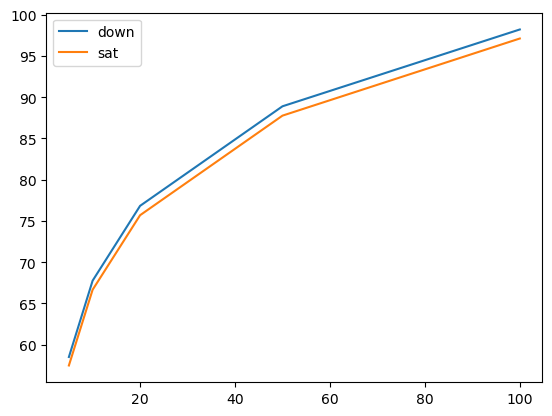

In [20]:
plt.plot(Tr, Mev_d[:,0,0],label='down')
plt.plot(Tr, Mev_s[:,0,0],label='sat')
plt.legend()